/tmp/ipython-input-1657845417.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
/tmp/ipython-input-1657845417.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']


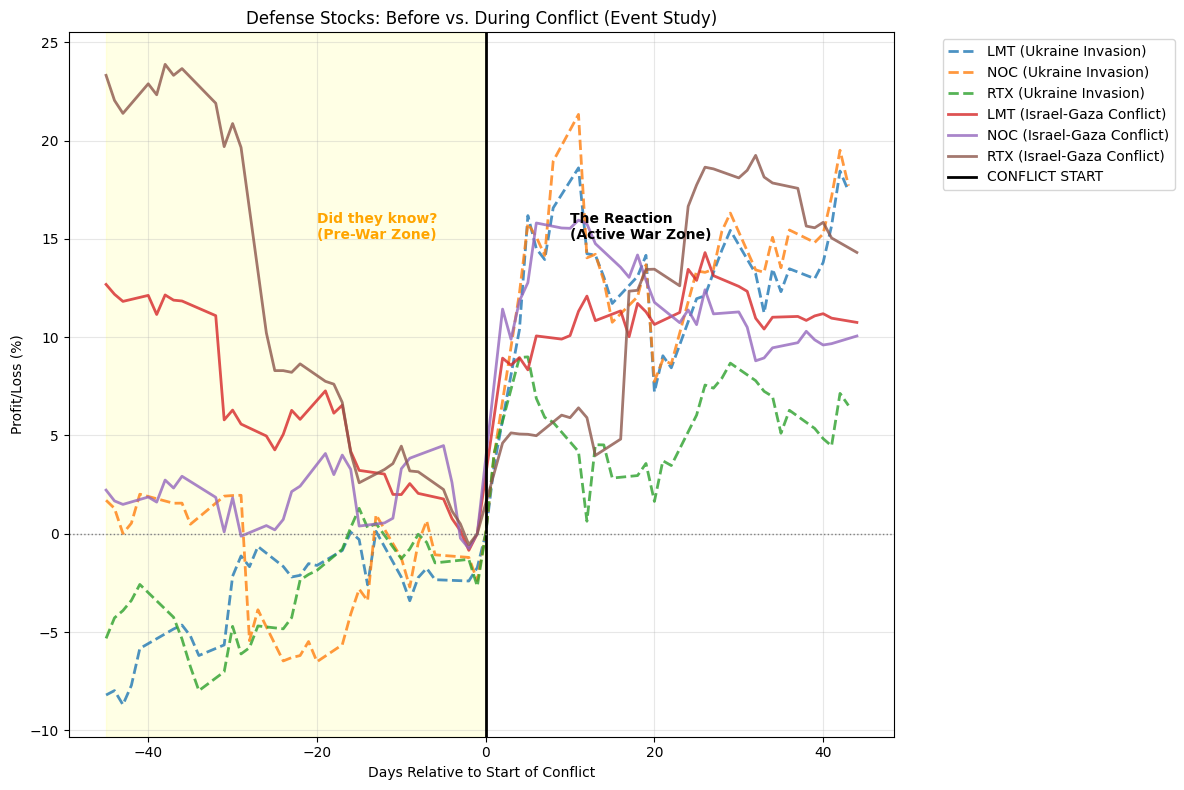

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- 1. CONFIGURATION ---
tickers = ['LMT', 'NOC', 'RTX']
events = {
    'Ukraine Invasion': '2022-02-24',
    'Israel-Gaza Conflict': '2023-10-07'
}
window_days = 45  # Look 45 days before and after

# --- 2. THE ENGINE ---
plt.figure(figsize=(12, 8))

# Loop through each conflict
for event_name, date_str in events.items():
    event_date = datetime.strptime(date_str, '%Y-%m-%d')
    start_date = event_date - timedelta(days=window_days)
    end_date = event_date + timedelta(days=window_days)

    # Download data for this specific window
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']

    # We need to re-index the dates to be "Days Relative to War Start" (Day -30, Day 0, Day +30)
    # This aligns the charts so we can compare them directly.

    # Create an "Average Defense Portfolio" for this event
    # We normalize it so Day 0 (Start of War) = 100
    # This lets us see the % move relative to the start date.

    # Find the price closest to the event date to use as baseline
    # (Using simple integer location for approximation in this quick script)

    # Better approach: Loop through tickers and plot relative performance
    for ticker in tickers:
        prices = data[ticker].dropna()
        if len(prices) == 0: continue

        # Find index of the event date (or nearest)
        # We calculate days relative to event
        days_relative = []
        normalized_price = []

        # Get baseline price (Price on Day 0)
        try:
            # Find closest actual trading day to event
            baseline_date = prices.index[prices.index.get_indexer([event_date], method='nearest')[0]]
            baseline_price = prices.loc[baseline_date]
        except:
            continue

        for date, price in prices.items():
            delta = (date - event_date).days
            days_relative.append(delta)
            # Normalize: (Price / Baseline) - 1 = Percentage Change
            normalized_price.append((price / baseline_price - 1) * 100)

        # Plotting
        style = '--' if event_name == 'Ukraine Invasion' else '-'
        color = 'red' if ticker == 'LMT' else 'blue' if ticker == 'NOC' else 'green'

        plt.plot(days_relative, normalized_price,
                 label=f"{ticker} ({event_name})",
                 linestyle=style, linewidth=2, alpha=0.8)

# --- 3. VISUALS ---
plt.axvline(0, color='black', linewidth=2, label='CONFLICT START')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)

plt.title('Defense Stocks: Before vs. During Conflict (Event Study)')
plt.xlabel('Days Relative to Start of Conflict')
plt.ylabel('Profit/Loss (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside chart
plt.grid(True, alpha=0.3)

# Add "Insight" Zones
plt.axvspan(-window_days, 0, color='yellow', alpha=0.1)
plt.text(-20, 15, "Did they know?\n(Pre-War Zone)", fontsize=10, fontweight='bold', color='orange')
plt.text(10, 15, "The Reaction\n(Active War Zone)", fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()